In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat

In [2]:
# creating paths


path = "SavedModels/SyntheticMasked/"
date = '2023-12-17' # 2
config_name = 'config_001_maskeddirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_maskeddirect.pt'



path = "SavedModels/SyntheticBert/"
date = '2023-12-20' # 2
config_name = 'config_001_bert500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_bert500K.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-14' # 2
config_name = 'config_001_unet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_unet.pt' #  model_299999_hollowMLEProb.pt


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_bert.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_19999_bert.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_349999.pt'



path = 'SavedModels/BIN-MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-17' # 2
config_name = 'config_001_unet3M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_unet3M.pt' 


path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_349999.pt'



path = 'SavedModels/MAZEprotein/'
date = "2023-12-23"
config_name = "config_001_score.yaml"
model_name = "model_199999_score.pt"

path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-23' # 2
config_name = 'config_001.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_9999.pt' #  model_299999_hollowMLEProb.pt


path = 'SavedModels/MAZEprotein/'
date = "2023-12-23"
config_name = "config_001_score.yaml"
model_name = "model_199999_score.pt"

path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-23' # 2
config_name = 'config_001.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_69999.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_349999.pt'

path = "SavedModels/SyntheticBert/"
date = '2023-12-23' # 2
config_name = 'config_001_uniform.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999.pt'

path = "SavedModels/SyntheticMasked/"
date = '2023-12-24' # 2
config_name = 'config_001_maskedelbo.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_maskedelbo.pt'

path = "SavedModels/SyntheticBert/"
date = '2023-12-20' # 2
config_name = 'config_001_bert500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_bert500K.pt'

path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-28' # 2
config_name = 'config_001_unetlog.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_unetlog.pt' #  model_299999_hollowMLEProb.pt

path = "SavedModels/SyntheticBert/"
date = '2023-12-20' # 2
config_name = 'config_001_bert500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_bert500K.pt'

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)



In [3]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'ElboTauL' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 500
cfg.sampler.is_ordinal = False

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

# Maze:
# 80% TauL
# 84% LBJF
# 96%

number of parameters:  504834
ema state dict function


In [4]:
n_samples = 25
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

0it [00:00, ?it/s]

4it [00:01,  3.28it/s]

tensor(0.7713, device='cuda:0')
tensor(0.0600, device='cuda:0')
tensor(0.0437, device='cuda:0')
tensor(0.0250, device='cuda:0')
tensor(0.0275, device='cuda:0')


8it [00:01,  7.16it/s]

tensor(0.0187, device='cuda:0')
tensor(0.0162, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0262, device='cuda:0')


12it [00:01, 11.14it/s]

tensor(0.0200, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0175, device='cuda:0')
tensor(0.0150, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0200, device='cuda:0')
tensor(0.0150, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0162, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')


23it [00:02, 30.30it/s]

tensor(0.0100, device='cuda:0')
tensor(0.0162, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0187, device='cuda:0')


28it [00:02, 24.79it/s]

tensor(0.0100, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0150, device='cuda:0')


35it [00:02, 22.35it/s]

tensor(0.0112, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0075, device='cuda:0')


38it [00:02, 21.55it/s]

tensor(0.0062, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0100, device='cuda:0')


51it [00:03, 36.75it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0100, device='cuda:0')


56it [00:03, 28.27it/s]

tensor(0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0075, device='cuda:0')


60it [00:03, 25.83it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0075, device='cuda:0')


63it [00:03, 24.09it/s]

tensor(0.0050, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0100, device='cuda:0')


73it [00:04, 32.09it/s]

tensor(0.0112, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0100, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0050, device='cuda:0')


79it [00:04, 35.30it/s]

tensor(0.0137, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0050, device='cuda:0')


83it [00:04, 28.49it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0088, device='cuda:0')


90it [00:04, 24.03it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0025, device='cuda:0')


93it [00:04, 22.66it/s]

tensor(0.0062, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0100, device='cuda:0')


106it [00:05, 35.74it/s]

tensor(0.0062, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0137, device='cuda:0')
tensor(0.0037, device='cuda:0')


110it [00:05, 28.92it/s]

tensor(0.0062, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0037, device='cuda:0')


114it [00:05, 25.73it/s]

tensor(0.0088, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0088, device='cuda:0')


117it [00:05, 24.01it/s]

tensor(0.0050, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0050, device='cuda:0')


125it [00:05, 28.15it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0037, device='cuda:0')


133it [00:06, 35.43it/s]

tensor(0.0050, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0112, device='cuda:0')
tensor(0.0075, device='cuda:0')


137it [00:06, 28.78it/s]

tensor(0.0062, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0050, device='cuda:0')


141it [00:06, 25.81it/s]

tensor(0.0037, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')


144it [00:06, 24.08it/s]

tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')


152it [00:06, 28.23it/s]

tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0050, device='cuda:0')


160it [00:07, 38.21it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')


165it [00:07, 28.92it/s]

tensor(0.0050, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')


169it [00:07, 26.13it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')


176it [00:07, 22.85it/s]

tensor(0.0062, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0025, device='cuda:0')


187it [00:08, 37.38it/s]

tensor(0.0100, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')


192it [00:08, 28.03it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')


196it [00:08, 25.87it/s]

tensor(0.0037, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0062, device='cuda:0')


200it [00:08, 23.87it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0088, device='cuda:0')
tensor(0.0062, device='cuda:0')


214it [00:09, 36.95it/s]

tensor(0.0075, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')


219it [00:09, 29.08it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')


223it [00:09, 26.33it/s]

tensor(0.0050, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')


227it [00:09, 24.12it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')


230it [00:09, 23.02it/s]

tensor(0.0050, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0025, device='cuda:0')


244it [00:10, 32.92it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')


248it [00:10, 27.69it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0075, device='cuda:0')
tensor(0.0025, device='cuda:0')


252it [00:10, 24.85it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')


255it [00:10, 23.43it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')


269it [00:11, 37.58it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


278it [00:11, 27.38it/s]

tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')


282it [00:11, 24.81it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')


285it [00:11, 23.42it/s]

tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0050, device='cuda:0')


298it [00:12, 34.20it/s]

tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')


302it [00:12, 28.14it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')


306it [00:12, 25.88it/s]

tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0., device='cuda:0')


312it [00:12, 23.37it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')


326it [00:13, 37.53it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')


330it [00:13, 30.30it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')


334it [00:13, 26.60it/s]

tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')


337it [00:13, 24.63it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')


345it [00:13, 28.36it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')


354it [00:14, 39.72it/s]

tensor(0.0062, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')


359it [00:14, 30.50it/s]

tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')


363it [00:14, 27.81it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')


370it [00:14, 23.82it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')


379it [00:14, 36.67it/s]

tensor(0., device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')


384it [00:15, 34.42it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')


389it [00:15, 27.92it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')


396it [00:15, 24.76it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


410it [00:15, 40.43it/s]

tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


419it [00:16, 28.29it/s]

tensor(0.0025, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')


423it [00:16, 25.29it/s]

tensor(0.0012, device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0012, device='cuda:0')


430it [00:16, 27.31it/s]

tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


440it [00:16, 42.84it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0037, device='cuda:0')
tensor(0.0012, device='cuda:0')


446it [00:17, 31.83it/s]

tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')


455it [00:17, 26.08it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


471it [00:17, 42.45it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0025, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')


477it [00:18, 32.31it/s]

tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


482it [00:18, 29.23it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


490it [00:18, 26.62it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0., device='cuda:0')


500it [00:18, 26.48it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [5]:
is_img = True# cfg.data.is_img

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)

 
    saving_plot_path = os.path.join(path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    saving_np_path = os.path.join(path, f"samples_{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.npy")
    np.save(f'{saving_np_path}', samples)

    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")

AttributeError: "'image_size'"

3
5
6
7
9
10
11
16
18
21
22
24
Accuracy: From 25 are 52.0% solvable.


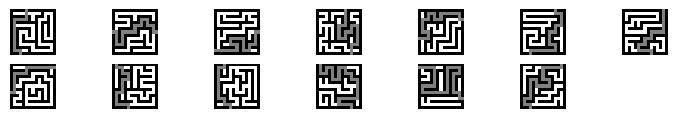

In [ ]:
correct_mazes = maze_acc(saved_samples)
correct_mazes = correct_mazes[:, np.newaxis, :, :]

fig = plt.figure(figsize=(9, 2)) 
n_c = correct_mazes.shape[0]
n_cols = 2
if n_c % 2 == 0:
    n_rows = int(n_c / n_cols)
else:
    n_rows = int(np.ceil(n_c /n_cols))
    #n_c = n_c - 1
    n_cols = 3
for i in range(n_c):
    plt.subplot(n_cols, n_rows, 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(correct_mazes[i, ...], (1,2,0)), cmap="gray")
plt.show()
 


[0.008355556055903435, 0.00568888895213604, 0.00711111119017005, 0.006755555514246225, 0.008177777752280235, 0.01066666655242443, 0.007466666866093874, 0.00711111119017005, 0.006577777676284313, 0.010311110876500607, 0.0069333333522081375, 0.007822222076356411, 0.006044444628059864, 0.0069333333522081375, 0.006400000303983688, 0.007288889028131962, 0.007466666866093874, 0.007822222076356411, 0.00800000037997961, 0.009066666476428509, 0.01066666655242443, 0.008888889104127884, 0.00853333342820406, 0.00711111119017005, 0.009244444780051708, 0.008888889104127884, 0.007466666866093874, 0.009777777828276157, 0.009422222152352333, 0.005866666790097952, 0.008355556055903435, 0.007288889028131962, 0.00853333342820406, 0.0069333333522081375, 0.012088889256119728, 0.007644444704055786, 0.00800000037997961, 0.009244444780051708, 0.009600000455975533, 0.00800000037997961, 0.007466666866093874, 0.00853333342820406, 0.008711110800504684, 0.006577777676284313, 0.00853333342820406, 0.00764444470405578

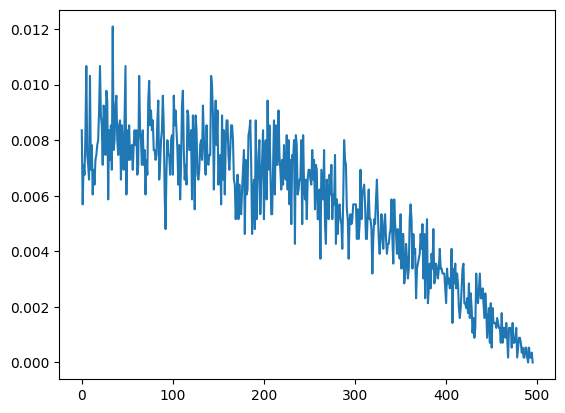

In [ ]:
plt.plot(changes)
print(changes)
plt.show()